# Choosing 401(k)'s with Bayesian Inference

I'm apparently an adult now that I got a job, moved to Brooklyn with the boyfriend, with a dog and a station wagon, etc. One of the many "fun" things about adulting is that I even though I'm in my late-20s, I get to start worrying about ~~dying~~ retiring!? 

I've procrastinated long enough on actually doing something with my retirement money, so I finally decided to start investigating my options. 

A simple way to compare the funds would be to simply look at returns or growth rates. But for me at least, another important consideration would be whether the funds I choose can withstand market crashes because I want to keep my retirement money relatively safe. After all, it would suck to lose it all and be broke when I'm old and want to do retirement stuff instead of working!

You can compute the [volatility](http://www.investopedia.com/terms/v/volatility.asp), of the funds you might be interested in by simply taking its standard deviation. However, the market is a bit more complicated than that. A [stochastic volatility](http://www.investopedia.com/terms/s/stochastic-volatility.asp "stochastic volatility") model considers co-dependancy between variables underlying the volatility. This complex problem can be modeled using Bayesian inference. In my experience, I found the [pymc3](https://github.com/pymc-devs/pymc3) package to be very efficient at Bayesian modeling in Python. 

First, I'll just need to import some basic things into my python environment:

In [1]:
import matplotlib.pyplot as plt
import numpy as np

Next, I will need to attain some benchmark data to compare with the retirement funds. I can pull market data from Yahoo easily using pandas-datareader. There are many market indicies I can use, but for now, I'll just look at the returns from the S&P 500. Since I want to minimize risk with my retirement funds, I'm interested in comparing volatilities around the Great Recession of 2008. 

In [2]:
try:
    from pandas_datareader import data
except ImportError:
    #!pip install pandas-datareader
    import pip
    pip.main(['install', 'pandas-datareader']) 
    from pandas_datareader import data
returns = data.get_data_yahoo('SPY', start='2008-5-1', end='2009-12-1')['Adj Close'].pct_change()

Now, let's define a model. I imagine there are many possible models availible, each with their own merits. I'm not a finance expert, so I'll simply use a model previously proposed [here](https://peerj.com/articles/cs-55.pdf), which is summarized below:
$$ 
\begin{align}
\sigma &\sim \exp(50) \\
\nu &\sim \exp(0.1) \\
s_i &\sim \mathrm{Normal} (s_{i-1}, \sigma^2) \\
\log(y_i) &\sim \mathrm{StudentT}(\nu, 0, \exp(-2s_i)) 
\end{align}
$$

In brief, the latent volatilities $ s $ is modeled as a Random Walk using a Gaussian prior with a spread of $ \sigma $, which itself is chosen from an exponential distribution. The response $ y $, or the returns, is modeled as a Student's-T distribution with unknown degrees of freedom (or $ \nu $, which we sampled from an exponential prior).

Within pymc3, this model would be defined as:

In [3]:
from pymc3 import Model
from pymc3 import Exponential, StudentT, Deterministic
from pymc3.distributions.timeseries import GaussianRandomWalk
from pymc3.math import exp
with Model() as sp500_model:
    nu = Exponential('nu', 1./10, testval=5.)
    sigma = Exponential('sigma', 1./.02, testval=.1)
    s = GaussianRandomWalk('s', sigma**-2, shape=len(returns))
    volatility_process = Deterministic('volatility_process', exp(-2*s))
    r = StudentT('r', nu, lam=1/volatility_process, observed=returns)

With the model defined, we can take samples from the priors we've defined:

In [4]:
from pymc3 import variational
from pymc3 import NUTS, sample
from scipy import optimize
with sp500_model:
    mkt_trace = sample(2000, progressbar=False)

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average ELBO = 883.15: 100%|█████████| 200000/200000 [00:45<00:00, 4361.67it/s]
Finished [100%]: Average ELBO = 883.42


Quickly, let's plot the Bayesian-modeled volatilities with the market returns to see if they make sense:

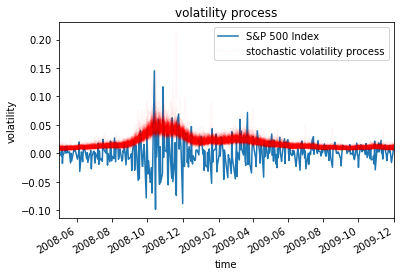

In [5]:
fig, ax = plt.subplots()
returns.plot(ax=ax)
ax.plot(returns.index, 1/np.exp(mkt_trace['s',::5].T), 'r', alpha=.03);
ax.set(title='volatility process', xlabel='time', ylabel='volatility');
ax.legend(['S&P 500 Index', 'stochastic volatility process'])
plt.show()

Intuitively, volatility of the S&P 500 (shown in red) increased dramatically when the market crashed, and this increase in volatility matches the increase in the variance of returns as well. Over time as the economy recovered from the recession, the volatility decreases as well. From what I see here, this makes sense.

Time to start analyzing retirement fund volatilities! Just for quick illustration here, I will pull example returns from the Thrift Savings Plan (TSP) database during the same time, again using pandas-datareader. Before analyzing though, it needs to be cleaned a little (removing empty columns mostly).

In [6]:
import pandas_datareader.tsp as tsp
tspreader = tsp.TSPReader(start='2008-5-1', end='2009-12-1').read()
tspreader = tspreader.dropna()
tspreader = tspreader.drop('L 2050', axis=1)
tspreader = tspreader.drop('', axis=1)

Now, I just have to re-run the model for each fund and compare results with the market volatility indices! Let's see how much variation of volatility is present between different retirement fund offerings...

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average ELBO = 1,381.1: 100%|████████| 200000/200000 [00:47<00:00, 4223.42it/s]
Finished [100%]: Average ELBO = 1,381.3


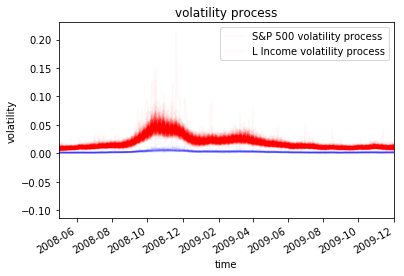

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average ELBO = 948.63: 100%|█████████| 200000/200000 [00:46<00:00, 4306.63it/s]
Finished [100%]: Average ELBO = 948.73


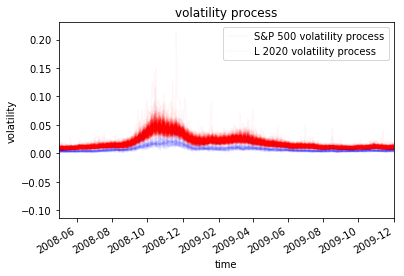

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average ELBO = 876.08: 100%|█████████| 200000/200000 [00:45<00:00, 4355.87it/s]
Finished [100%]: Average ELBO = 876.09


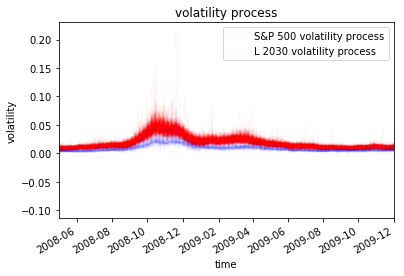

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average ELBO = 824.11: 100%|█████████| 200000/200000 [00:46<00:00, 4334.26it/s]
Finished [100%]: Average ELBO = 824.17


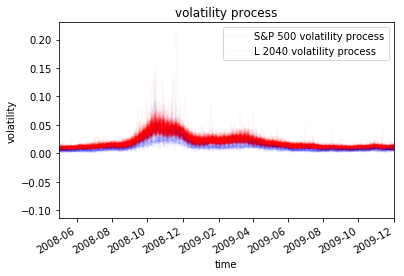

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average ELBO = 2,707.7: 100%|████████| 200000/200000 [00:44<00:00, 4471.77it/s]
Finished [100%]: Average ELBO = 2,733.8


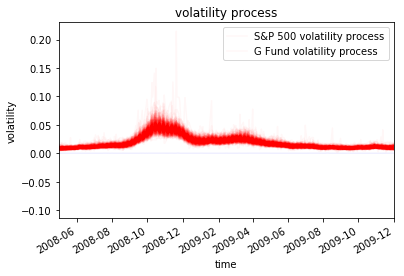

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average ELBO = 1,437.4: 100%|████████| 200000/200000 [00:45<00:00, 4378.76it/s]
Finished [100%]: Average ELBO = 1,437


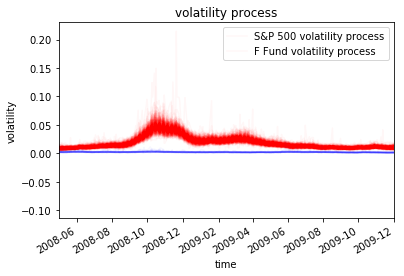

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average ELBO = 745.14: 100%|█████████| 200000/200000 [00:46<00:00, 4315.37it/s]
Finished [100%]: Average ELBO = 744.7


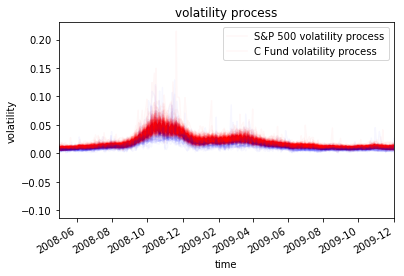

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average ELBO = 682.62: 100%|█████████| 200000/200000 [00:46<00:00, 4261.85it/s]
Finished [100%]: Average ELBO = 682.77


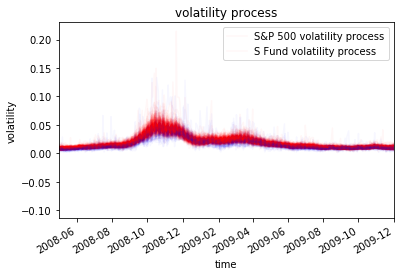

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average ELBO = 727.86: 100%|█████████| 200000/200000 [00:48<00:00, 4112.69it/s]
Finished [100%]: Average ELBO = 727.78


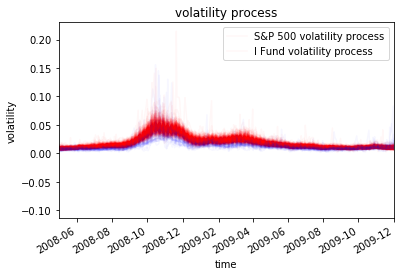

In [8]:
for i in range(len(tspreader.columns)):
    fund_returns = tspreader.iloc[:,i].pct_change()
    with Model() as fund_model:
        nu_f = Exponential('nu', 50, testval=5.)
        sigma_f = Exponential('sigma_f', 1./.02, testval=.1)
        s_f = GaussianRandomWalk('s_f', sigma_f**-2, shape=len(fund_returns))
        volatility_process_f = Deterministic('volatility_process_f', exp(-2*s_f))
        r_f = StudentT('r_f', nu_f, lam=1/volatility_process_f, observed=fund_returns)
    with fund_model:
        trace = sample(200, progressbar=False)
    fig, ax = plt.subplots()
    returns.plot(ax=ax)
    ax.lines[0].remove()
    ax.plot(returns.index,1/np.exp(mkt_trace['s',::5].T), 'r', alpha=.03);
    ax.plot(fund_returns.index,1/np.exp(trace['s_f',::5].T), 'b', alpha=.03);
    ax.set(title='volatility process', xlabel='time', ylabel='volatility');
    ax.legend(['S&P 500 volatility process', str(list(tspreader)[i]) + ' ' + 'volatility process'])
    plt.show()

In general, it looks the volatilities for many TSP retirement funds are less than those experienced by the S&P 500, which makes sense. Presumably, retirement funds probably are more cautious than perhaps more traditional investments. 

I notice that some funds have flat volatilities around zero ("L Income", "F Fund", and "G Fund"). Having some proportion of savings in funds like these may be a good idea, or possibly these would be good candidate funds to transfer to if one senses the market will experience a downtown. 

Some of these funds have pretty dispersed results with similar mean volatility (for example "S Fund" vs. "2020 Fund"). To me, this indicates that some funds have less predictable volatilities than others. For me, I would probably select a fund that has less uncertainty (choosing "2020 Fund" over "S Fund").

Now with this tool, it's time for me to make some monetary decisions! Next step: fantasizing about my fabulous retirement!!